## OD Analysis
### Understanding the cyclists profile

This notebook aims to study the current characteristics of São Paulo bike trips.

With these analyses, we can identify attributes that may influentiate on the choice of bicycles.

In [1]:
# importing data and auxiliar functions

import saopaulo.sp_grid as gr
import bikescience.distributions as dist
from bikescience.slope import plot_slope, plot_slopes, split_route

import folium
import pandas as pd
import geopandas as gpd
from statistics import stdev
from ipywidgets import interact_manual, widgets, fixed
from IPython.core.display import display, HTML, clear_output
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import warnings
import requests
import os
warnings.simplefilter('ignore')
import time

/home/pedro/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
zone_shp = gpd.read_file('../data/sao-paulo/od/shapes/Zonas_2017_region.shp')
zone_shp.crs = {'init': 'epsg:31983'}  
zone_shp.to_crs(epsg='4326', inplace=True)

od_routes_sp = gpd.read_file('../data/sao-paulo/od/routes/bike_routes_in_sp.shp')
od_routes_sp.crs = {'init': 'epsg:4326'}
od_routes_sp['length'] = od_routes_sp['geometry'].length * 100000
the_grid = gr.create(n=10, west_offset=-0.15, east_offset=0.23, north_offset=0.19, south_offset=-0.46)

total_trips = sum(od_routes_sp['FE_VIA'])
eps = 1e-5

# FE_VIA is the expasion factor, i.e.,
# in the original source, suppose there is on record with FE_VIA 50
# then, there will be 50 records in this od_routes_FE_VIA

od_routes_FE_VIA = []
for i, r in od_routes_sp.iterrows():
    for w in range(round(r['FE_VIA'])):
        od_routes_FE_VIA.append(r)
        
od_routes_FE_VIA = pd.DataFrame(data = od_routes_FE_VIA, columns = od_routes_sp.columns)

In [4]:
# return a list [value_10, value_20, ..., value_100] 
# where value_x is the value whose x% of the data is less than it
# useful to generate data for latex graphs
def stats (data, value, weights = 'FE_VIA'):
    level = sum(data[weights])/10
    stats = []
    data = data.sort_values(value)
    total = 0
    for _, i in data.iterrows():
        total += i[weights]
        if total >= (len(stats) + 1) * level - eps:
            stats.append(i[value])
    return stats


In [5]:
# display(od_routes_FE_VIA)

# Distance

The first attribute we consider is the trip distance.

The longer a trip is, the less cyclable it is. The distance is calculated using the routes calculated by the GraphHopper API. 

However, very short trips are hard to migrate to cycling because they are most likely made on foot.

The current Sao Paulo bike trips distance distribution is represented in the following graphs.

distance  10%:	 994
distance  20%:	 1343
distance  30%:	 1759
distance  40%:	 2310
distance  50%:	 2893
distance  60%:	 3703
distance  70%:	 4545
distance  80%:	 6613
distance  90%:	 10372
distance  100%:	 48888


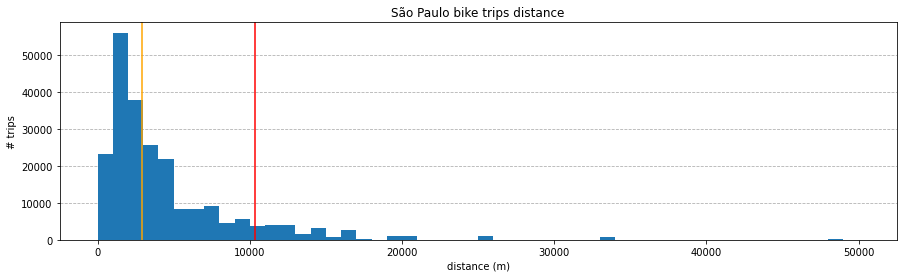

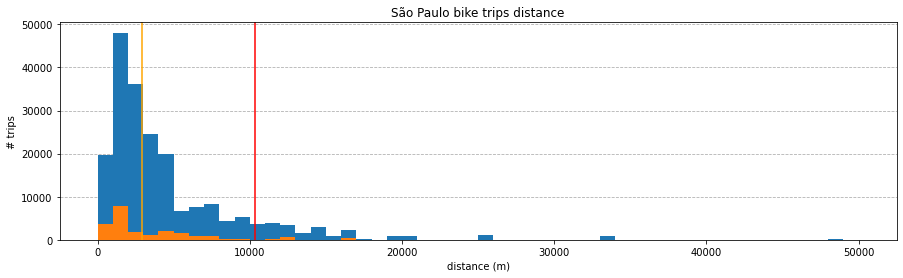

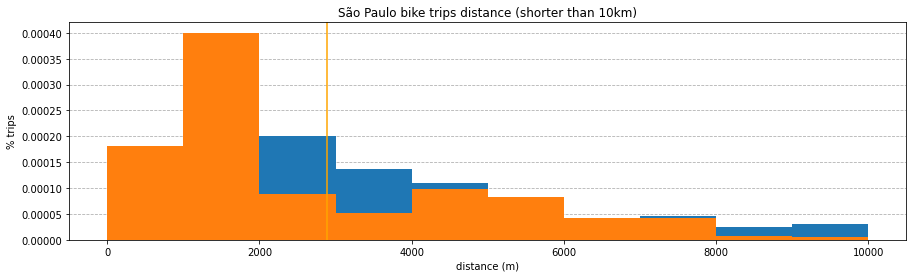

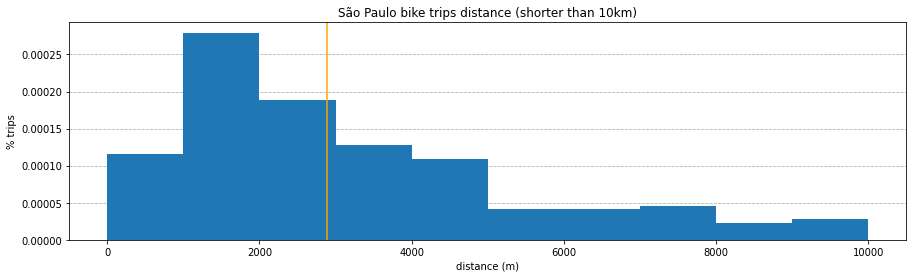

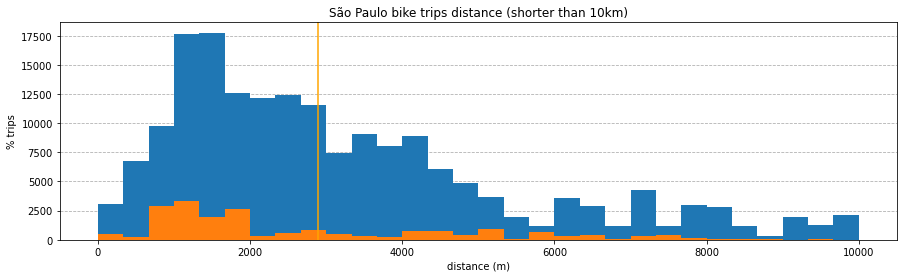

In [6]:
od_routes_sp = od_routes_sp.sort_values('length')

s = stats(od_routes_sp, 'length')
for i in range(10):
    print('distance  ' + str(i + 1) + '0%:\t', round(s[i]))
    
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=50, x=od_routes_sp['length'], 
         weights = od_routes_sp['FE_VIA'], range=(0, 50000))
plt.title('São Paulo bike trips distance')
plt.xlabel('distance (m)')
plt.ylabel('# trips')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()    

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=50, x=od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['FE_VIA'], range=(0, 50000))
plt.hist(bins=50, x=od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['FE_VIA'], range=(0, 50000))
plt.title('São Paulo bike trips distance')
plt.xlabel('distance (m)')
plt.ylabel('# trips')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=10,x=od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['FE_VIA'], range=(0,10000), density=True)
plt.hist(bins=10,x=od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['FE_VIA'], range=(0,10000), density=True)
plt.title('São Paulo bike trips distance (shorter than 10km)')
plt.xlabel('distance (m)')
plt.ylabel('% trips')
plt.axvline(x=s[4],color='orange')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=10,x=od_routes_sp['length'], 
         weights = od_routes_sp['FE_VIA'], range=(0,10000), density=True)
plt.title('São Paulo bike trips distance (shorter than 10km)')
plt.xlabel('distance (m)')
plt.ylabel('% trips')
plt.axvline(x=s[4],color='orange')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=30,x=od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['FE_VIA'], range=(0,10000))
plt.hist(bins=30,x=od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['FE_VIA'], range=(0,10000))
plt.title('São Paulo bike trips distance (shorter than 10km)')
plt.xlabel('distance (m)')
plt.ylabel('% trips')
plt.axvline(x=s[4],color='orange')
plt.show()

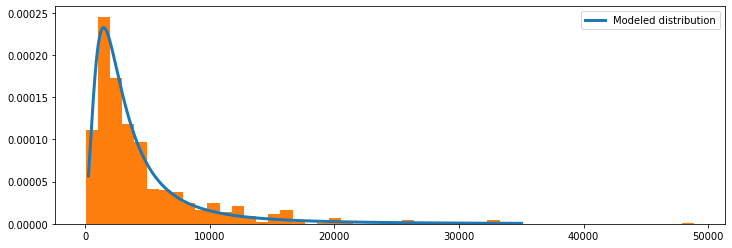

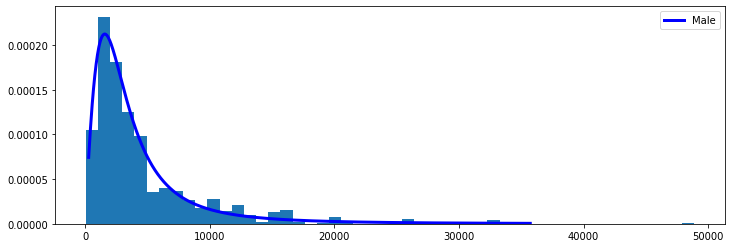

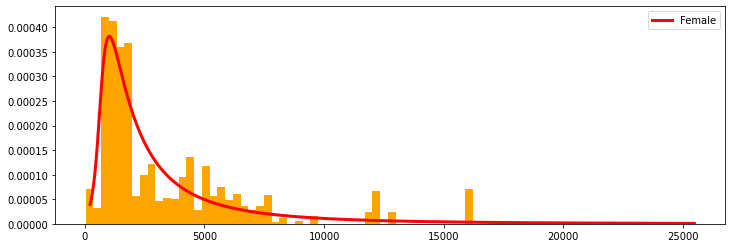

In [7]:
import scipy.stats as st

#display(distrib_weighted)
#'invweibull', (1.9570057637337088, -1328.576035175634, 3464.328480602161))

distance_pdf = dist.make_pdf(st.invweibull, (1.9570057637337088, -1328.576035175634, 3464.328480602161))
plt.figure(figsize=(12,4))
ax = distance_pdf.plot(lw=3, label='Modeled distribution', legend=True)
plt.hist(bins=50, x=od_routes_sp['length'], weights = od_routes_sp['FE_VIA'], density=True)
plt.show()

distance_pdf_m = dist.make_pdf(st.fisk, (1.846058042674543, 33.070799837068655, 2961.1647009341214))
plt.figure(figsize=(12,4))
ax = distance_pdf_m.plot(lw=3, label='Male', legend=True, color='blue')
plt.hist(bins=50, x=od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['FE_VIA'], density=True)
plt.show()

distance_pdf_f = dist.make_pdf(st.johnsonsu, (-1.6348791801316755, 0.8220563043475115, 599.1107992085285, 401.86433888871386))
plt.figure(figsize=(12,4))
ax = distance_pdf_f.plot(lw=3, label='Female', legend=True, color='red')
plt.hist(bins=50, x=od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['FE_VIA'], density=True,color='orange')
plt.show()

# Slope

In [8]:
# calculating statistics
stats_slope = []
for _, r in od_routes_sp.iterrows():
    s = {}
    stretchs = split_route(r['geometry'], 'line', False)
    s['fe_via'] = r['FE_VIA']
    s['length'] = r['length']
    s['max'] = max([s[1] for s in stretchs])
    s['mean'] = sum([s[1]*s[0].length for s in stretchs])/r.length * 100000
    s['mean_pos'] = sum([max(0,s[1])*s[0].length for s in stretchs])/r.length * 100000
    stretchs = split_route(r['geometry'], 20, False)
    s['std_height'] = stdev([st[0].coords[0][2] for st in stretchs])
    s['sum_elevs'] = sum (max(0, st[0].coords[0][2] - st[0].coords[1][2]) for st in stretchs)
    for i in range(-150, 150):
        s['meters_slope_' + str(i)] = 0
        s['meters_slope_max_' + str(i)] = 0
    meters_in_slope = 0
    current_slope = round(stretchs[0][1])
    for st in stretchs:
        s['meters_slope_' + str(round(st[1]))] += st[0].length * 100000
        if current_slope == round(st[1]):
            meters_in_slope += st[0].length * 100000
        else:
            s['meters_slope_max_' + str(current_slope)] = max(meters_in_slope, 
                                                              s['meters_slope_max_' + str(current_slope)])
            meters_in_slope = st[0].length * 100000
            current_slope = round(st[1])
    s['meters_slope_max_' + str(current_slope)] = max(meters_in_slope, 
                                                      s['meters_slope_max_' + str(current_slope)])
        
    stats_slope.append(i[1] for i in s.items())  
    
c = ['fe_via', 'length', 'max', 'mean', 'mean_pos', 'std_height', 'sum_elevs']
for i in range(-150,150):
    c += ['meters_slope_' + str(i)] + ['meters_slope_max_' + str(i)]
df_stats = pd.DataFrame(data = stats_slope, columns = c)

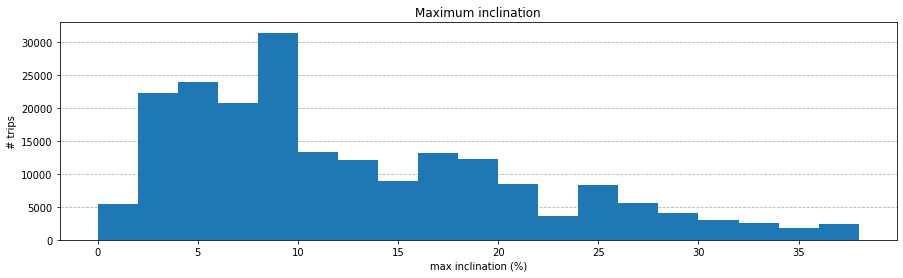

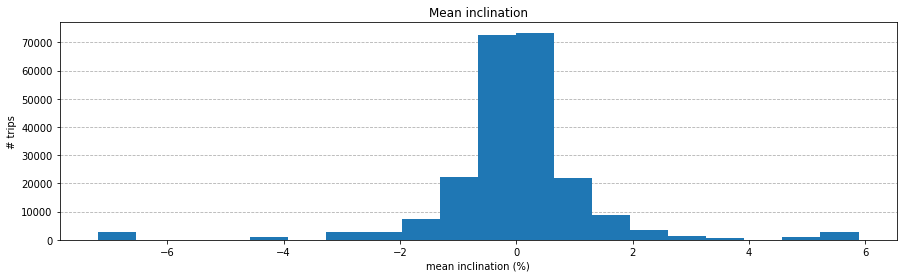

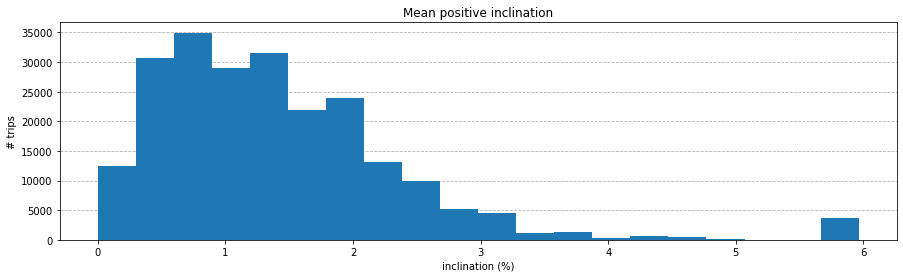

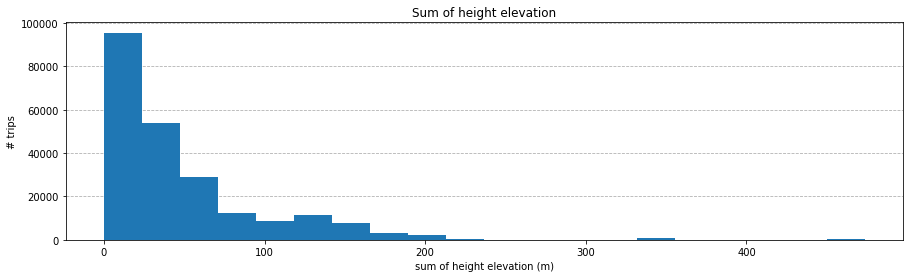

In [9]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=range(0,40,2), x=df_stats['max'], weights = df_stats['fe_via'])
plt.title('Maximum inclination')
plt.xlabel('max inclination (%)')
plt.ylabel('# trips')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['mean'], weights = df_stats['fe_via'])
plt.title('Mean inclination')
plt.xlabel('mean inclination (%)')
plt.ylabel('# trips')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['mean_pos'], weights = df_stats['fe_via'])
plt.title('Mean positive inclination')
plt.xlabel('inclination (%)')
plt.ylabel('# trips')
plt.show()
"""
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['std_height'], weights = df_stats['fe_via'])
plt.title('Height Standard Deviation')
plt.xlabel('height standard deviation (m)')
plt.ylabel('# trips')
plt.show()
"""
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['sum_elevs'], weights = df_stats['fe_via'])
plt.title('Sum of height elevation')
plt.xlabel('sum of height elevation (m)')
plt.ylabel('# trips')
plt.show()

In [12]:
df_stats['sum_elevs']


x = 0
while x <= 250:
    cyclists = sum(df_stats.loc[df_stats['sum_elevs'] >= x]
                   .loc[df_stats['sum_elevs'] < x + 20]['fe_via'])
    #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
    print('(' + str(x + 10) + ', ' + str(cyclists / 1000) + ')')
    x += 20
print('-----------------------------')

x = 0
while x <= 6:
    cyclists = sum(df_stats.loc[df_stats['mean_pos'] >= x]
                   .loc[df_stats['mean_pos'] < x + .20]['fe_via'])
    #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
    print('(' + str(x + .10) + ', ' + str(cyclists / 1000) + ')')
    x += .20
print('-----------------------------')
    
x = 0
while x <= 25:
    cyclists = sum(df_stats.loc[df_stats['max'] >= x]
                   .loc[df_stats['max'] < x + 1]['fe_via'])
    #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
    print('(' + str(x + .50) + ', ' + str(cyclists / 1000) + ')')
    x += 1


(10, 86.30085377999993)
(30, 48.95485937899997)
(50, 32.62285818599999)
(70, 17.84275285600001)
(90, 6.00998266)
(110, 7.308382631999999)
(130, 10.833852331)
(150, 5.694932325999999)
(170, 5.714609498)
(190, 1.188463287)
(210, 1.084925277)
(230, 0.206804346)
(250, 0.0)
-----------------------------
(0.1, 5.649083396999998)
(0.30000000000000004, 12.497571852)
(0.5, 25.129690473999986)
(0.7000000000000001, 22.809568733999985)
(0.9, 22.174032433000004)
(1.1, 19.513672639000003)
(1.3, 20.912121177)
(1.5, 17.960652308000004)
(1.7, 13.985234011)
(1.9, 13.472914816000001)
(2.0999999999999996, 16.372540566999998)
(2.3, 7.218355719)
(2.5, 9.380848474999997)
(2.7, 2.6009198340000004)
(2.9000000000000004, 3.797611722)
(3.1000000000000005, 2.3217154289999997)
(3.3000000000000007, 1.90081156)
(3.500000000000001, 0.7337053679999999)
(3.700000000000001, 1.1775946469999998)
(3.9000000000000012, 0.4864028609999999)
(4.1000000000000005, 0.0)
(4.300000000000001, 0.5760969420000001)
(4.500000000000001, 0.

In [14]:
print(sum(df_stats.loc[df_stats['mean_pos'] > 2]['fe_via']))
print(sum(df_stats['fe_via']))

50816.68038100002
224921.22222200045


### Sum of distances in each level

In [15]:
y = []
for i in range(0, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    y.append(meters_slope_i)
    
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})


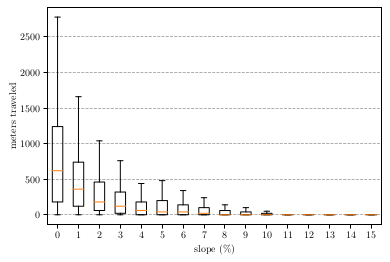

In [16]:

plt.figure(figsize=(6,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(y, positions=range(0,16), showfliers=False)
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.savefig('slopes_boxplot.pgf')
plt.show()

In [17]:
meters_slope_mean = []
meters_slope = []
meters_slope_center = []
meters_slope_up = []
meters_slope_down = []

for i in range(-150, 150):
    meters_slope_mean.append(sum(df_stats['meters_slope_' + str(i)] * df_stats['fe_via']) / total_trips)
    
for i in range(-15, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope.append(meters_slope_i)
    
for i in range(5, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope_up.append(meters_slope_i)

for i in range(-5, 6):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope_center.append(meters_slope_i)
    
for i in range(-5, -16, -1):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope_down.append(meters_slope_i)

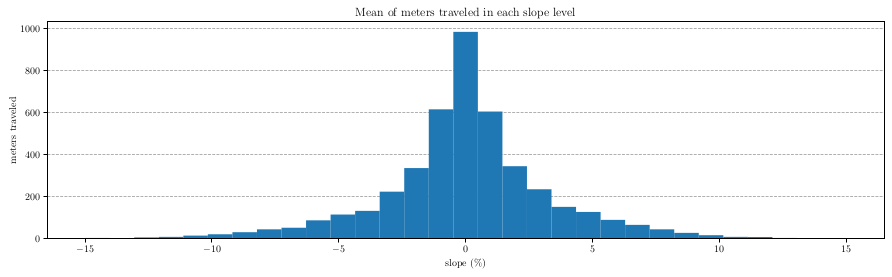

RuntimeError: The command
    pdflatex -interaction=nonstopmode -halt-on-error figure.tex
failed and generated the following output:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./figure.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/hyperref/hyperref.sty
(/usr/share/texlive/texmf-dist/tex/generic/ltxcmds/ltxcmds.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)
(/usr/share/texlive/texmf-dist/tex/latex/pdftexcmds/pdftexcmds.sty
(/usr/share/texlive/texmf-dist/tex/generic/infwarerr/infwarerr.sty))
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/kvsetkeys/kvsetkeys.sty)
(/usr/share/texlive/texmf-dist/tex/generic/kvdefinekeys/kvdefinekeys.sty)
(/usr/share/texlive/texmf-dist/tex/generic/pdfescape/pdfescape.sty)
(/usr/share/texlive/texmf-dist/tex/latex/hycolor/hycolor.sty)
(/usr/share/texlive/texmf-dist/tex/latex/letltxmacro/letltxmacro.sty)
(/usr/share/texlive/texmf-dist/tex/latex/auxhook/auxhook.sty)
(/usr/share/texlive/texmf-dist/tex/latex/kvoptions/kvoptions.sty)
(/usr/share/texlive/texmf-dist/tex/latex/hyperref/pd1enc.def)
(/usr/share/texlive/texmf-dist/tex/generic/intcalc/intcalc.sty)
(/usr/share/texlive/texmf-dist/tex/generic/etexcmds/etexcmds.sty)
(/usr/share/texlive/texmf-dist/tex/latex/url/url.sty)
(/usr/share/texlive/texmf-dist/tex/generic/bitset/bitset.sty
(/usr/share/texlive/texmf-dist/tex/generic/bigintcalc/bigintcalc.sty))
(/usr/share/texlive/texmf-dist/tex/generic/atbegshi/atbegshi.sty)

Package hyperref Warning: Option `pdfpagelabels' is turned off
(hyperref)                because \thepage is undefined.

) (/usr/share/texlive/texmf-dist/tex/latex/hyperref/hpdftex.def
(/usr/share/texlive/texmf-dist/tex/latex/rerunfilecheck/rerunfilecheck.sty
(/usr/share/texlive/texmf-dist/tex/latex/atveryend/atveryend.sty)
(/usr/share/texlive/texmf-dist/tex/generic/uniquecounter/uniquecounter.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/base/minimal.cls
Document Class: minimal 2001/05/25 Standard LaTeX minimal class
) (/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty))
(/usr/share/texlive/texmf-dist/tex/latex/pgf/basiclayer/pgf.sty
(/usr/share/texlive/texmf-dist/tex/latex/pgf/utilities/pgfrcs.sty
(/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfutil-common.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfutil-common-lists.t
ex)) (/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfutil-latex.def
(/usr/share/texlive/texmf-dist/tex/latex/ms/everyshi.sty))
(/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfrcs.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/pgf.revision.tex)))
(/usr/share/texlive/texmf-dist/tex/latex/pgf/basiclayer/pgfcore.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphicx.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphics.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/trig.sty)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/graphics.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-def/pdftex.def)))
(/usr/share/texlive/texmf-dist/tex/latex/pgf/systemlayer/pgfsys.sty
(/usr/share/texlive/texmf-dist/tex/generic/pgf/systemlayer/pgfsys.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfkeys.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfkeysfiltered.code.t
ex)) (/usr/share/texlive/texmf-dist/tex/generic/pgf/systemlayer/pgf.cfg)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/systemlayer/pgfsys-pdftex.def
(/usr/share/texlive/texmf-dist/tex/generic/pgf/systemlayer/pgfsys-common-pdf.de
f)))
(/usr/share/texlive/texmf-dist/tex/generic/pgf/systemlayer/pgfsyssoftpath.code.
tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/systemlayer/pgfsysprotocol.code.
tex)) (/usr/share/texlive/texmf-dist/tex/latex/xcolor/xcolor.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/color.cfg))
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcore.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmath.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathcalc.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathutil.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathparser.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.basic.code
.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.trigonomet
ric.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.random.cod
e.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.comparison
.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.base.code.
tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.round.code
.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.misc.code.
tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.integerari
thmetics.code.tex)))
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfloat.code.tex))
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfint.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorepoints.code.te
x)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorepathconstruct.
code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorepathusage.code
.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorescopes.code.te
x)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcoregraphicstate.c
ode.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcoretransformation
s.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorequick.code.tex
)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcoreobjects.code.t
ex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorepathprocessing
.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorearrows.code.te
x)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcoreshade.code.tex
)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcoreimage.code.tex

(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcoreexternal.code.
tex))
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorelayers.code.te
x)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcoretransparency.c
ode.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorepatterns.code.
tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorerdf.code.tex))
)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/modules/pgfmoduleshapes.code.tex
) (/usr/share/texlive/texmf-dist/tex/generic/pgf/modules/pgfmoduleplot.code.tex
)
(/usr/share/texlive/texmf-dist/tex/latex/pgf/compatibility/pgfcomp-version-0-65
.sty)
(/usr/share/texlive/texmf-dist/tex/latex/pgf/compatibility/pgfcomp-version-1-18
.sty)) (/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-pdfmode.def
)
No file figure.aux.
(/usr/share/texlive/texmf-dist/tex/latex/hyperref/nameref.sty
(/usr/share/texlive/texmf-dist/tex/latex/refcount/refcount.sty)
(/usr/share/texlive/texmf-dist/tex/generic/gettitlestring/gettitlestring.sty))
*geometry* driver: auto-detecting
*geometry* detected driver: pdftex
ABD: EveryShipout initializing macros
(/usr/share/texlive/texmf-dist/tex/context/base/mkii/supp-pdf.mkii
[Loading MPS to PDF converter (version 2006.09.02).]
) (/usr/share/texlive/texmf-dist/tex/latex/epstopdf-pkg/epstopdf-base.sty
(/usr/share/texlive/texmf-dist/tex/latex/latexconfig/epstopdf-sys.cfg))
(./figure.pgf
Runaway text?
q 0.0 -3.0004 m 0.79541 -3.0004 1.55898 -2.68398 2.12148 -2.12148 c 2\ETC.
! TeX capacity exceeded, sorry [main memory size=5000000].
<argument> ...41 2.68398 1.55898 2.12148 2.12148 c
                                                   1.55898 2.68398 0.79541 3...
l.40384 \pgfsys@useobject{currentmarker}{}
                                          %
!  ==> Fatal error occurred, no output PDF file produced!
Transcript written on figure.log.

and the following error:


<Figure size 1080x576 with 1 Axes>

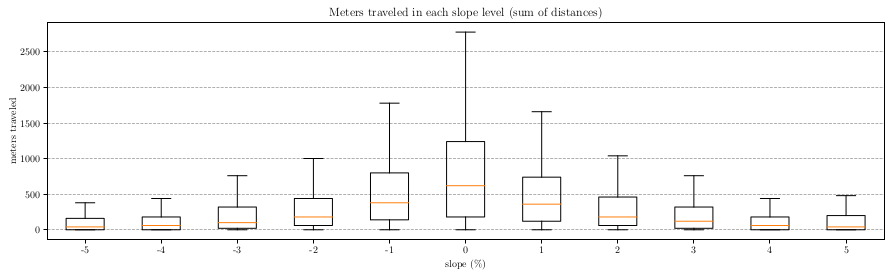

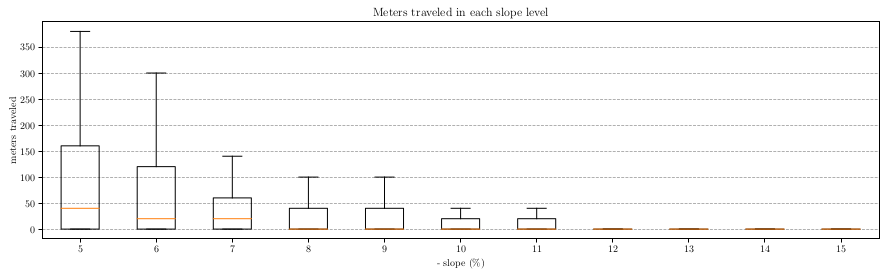

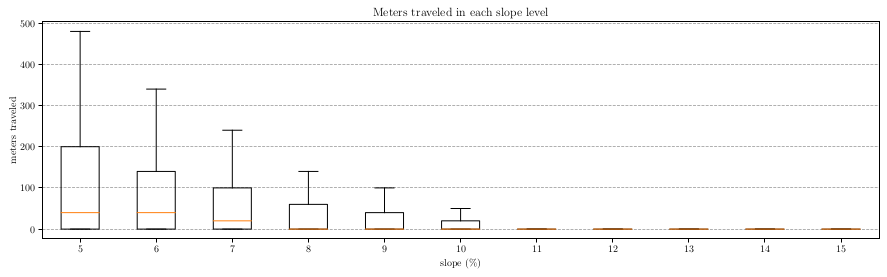

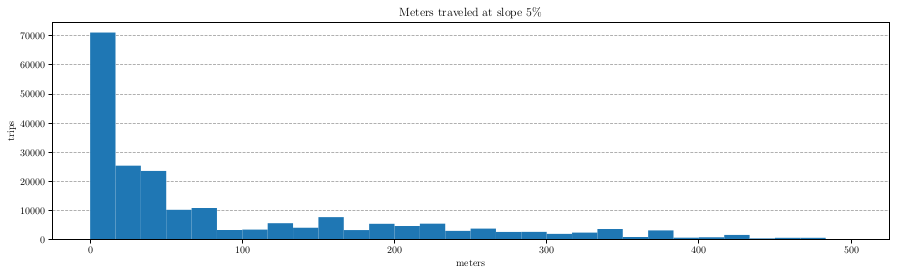

In [22]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=31, x=range(-150, 150), weights=meters_slope_mean, range=(-15, 15))
plt.title('Mean of meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,8))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope, positions=range(-15,16))
plt.title('Meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_center, positions=range(-5,6), showfliers=False)
plt.title('Meters traveled in each slope level (sum of distances)')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

pos = range(5,16)
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_down, positions=pos, showfliers=False)
plt.title('Meters traveled in each slope level')
plt.xlabel('- slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_up, positions=range(5,16), showfliers=False)
plt.title('Meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()


s = stats(df_stats, 'meters_slope_5', 'fe_via')

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=30, x=df_stats['meters_slope_5'], weights=df_stats['fe_via'], range=(0, 500))
plt.title('Meters traveled at slope 5%')
plt.xlabel('meters')
plt.ylabel('trips')
plt.show()

### Maximum distance in each level

In [23]:
meters_slope_mean = []
meters_slope = []
meters_slope_center = []
meters_slope_up = []
meters_slope_down = []

for i in range(-150, 150):
    meters_slope_mean.append(sum(df_stats['meters_slope_max_' + str(i)] * df_stats['fe_via']) / total_trips)
    
for i in range(-15, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_max_' + str(i)])
    meters_slope.append(meters_slope_i)
    
for i in range(5, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_max_' + str(i)])
    meters_slope_up.append(meters_slope_i)

for i in range(-5, 6):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_max_' + str(i)])
    meters_slope_center.append(meters_slope_i)
    
for i in range(-5, -16, -1):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_max_' + str(i)])
    meters_slope_down.append(meters_slope_i)

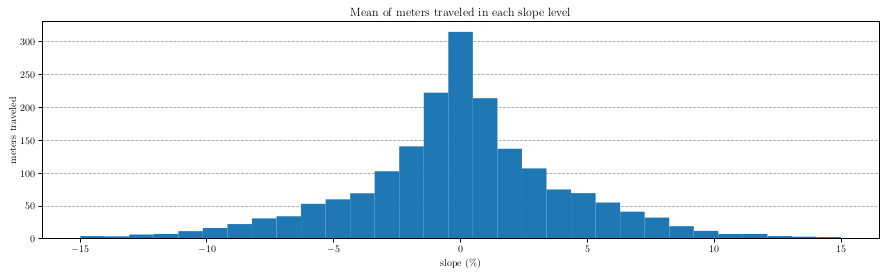

RuntimeError: The command
    pdflatex -interaction=nonstopmode -halt-on-error figure.tex
failed and generated the following output:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./figure.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/hyperref/hyperref.sty
(/usr/share/texlive/texmf-dist/tex/generic/ltxcmds/ltxcmds.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)
(/usr/share/texlive/texmf-dist/tex/latex/pdftexcmds/pdftexcmds.sty
(/usr/share/texlive/texmf-dist/tex/generic/infwarerr/infwarerr.sty))
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/kvsetkeys/kvsetkeys.sty)
(/usr/share/texlive/texmf-dist/tex/generic/kvdefinekeys/kvdefinekeys.sty)
(/usr/share/texlive/texmf-dist/tex/generic/pdfescape/pdfescape.sty)
(/usr/share/texlive/texmf-dist/tex/latex/hycolor/hycolor.sty)
(/usr/share/texlive/texmf-dist/tex/latex/letltxmacro/letltxmacro.sty)
(/usr/share/texlive/texmf-dist/tex/latex/auxhook/auxhook.sty)
(/usr/share/texlive/texmf-dist/tex/latex/kvoptions/kvoptions.sty)
(/usr/share/texlive/texmf-dist/tex/latex/hyperref/pd1enc.def)
(/usr/share/texlive/texmf-dist/tex/generic/intcalc/intcalc.sty)
(/usr/share/texlive/texmf-dist/tex/generic/etexcmds/etexcmds.sty)
(/usr/share/texlive/texmf-dist/tex/latex/url/url.sty)
(/usr/share/texlive/texmf-dist/tex/generic/bitset/bitset.sty
(/usr/share/texlive/texmf-dist/tex/generic/bigintcalc/bigintcalc.sty))
(/usr/share/texlive/texmf-dist/tex/generic/atbegshi/atbegshi.sty)

Package hyperref Warning: Option `pdfpagelabels' is turned off
(hyperref)                because \thepage is undefined.

) (/usr/share/texlive/texmf-dist/tex/latex/hyperref/hpdftex.def
(/usr/share/texlive/texmf-dist/tex/latex/rerunfilecheck/rerunfilecheck.sty
(/usr/share/texlive/texmf-dist/tex/latex/atveryend/atveryend.sty)
(/usr/share/texlive/texmf-dist/tex/generic/uniquecounter/uniquecounter.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/base/minimal.cls
Document Class: minimal 2001/05/25 Standard LaTeX minimal class
) (/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty))
(/usr/share/texlive/texmf-dist/tex/latex/pgf/basiclayer/pgf.sty
(/usr/share/texlive/texmf-dist/tex/latex/pgf/utilities/pgfrcs.sty
(/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfutil-common.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfutil-common-lists.t
ex)) (/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfutil-latex.def
(/usr/share/texlive/texmf-dist/tex/latex/ms/everyshi.sty))
(/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfrcs.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/pgf.revision.tex)))
(/usr/share/texlive/texmf-dist/tex/latex/pgf/basiclayer/pgfcore.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphicx.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphics.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/trig.sty)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/graphics.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-def/pdftex.def)))
(/usr/share/texlive/texmf-dist/tex/latex/pgf/systemlayer/pgfsys.sty
(/usr/share/texlive/texmf-dist/tex/generic/pgf/systemlayer/pgfsys.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfkeys.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfkeysfiltered.code.t
ex)) (/usr/share/texlive/texmf-dist/tex/generic/pgf/systemlayer/pgf.cfg)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/systemlayer/pgfsys-pdftex.def
(/usr/share/texlive/texmf-dist/tex/generic/pgf/systemlayer/pgfsys-common-pdf.de
f)))
(/usr/share/texlive/texmf-dist/tex/generic/pgf/systemlayer/pgfsyssoftpath.code.
tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/systemlayer/pgfsysprotocol.code.
tex)) (/usr/share/texlive/texmf-dist/tex/latex/xcolor/xcolor.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/color.cfg))
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcore.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmath.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathcalc.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathutil.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathparser.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.basic.code
.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.trigonomet
ric.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.random.cod
e.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.comparison
.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.base.code.
tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.round.code
.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.misc.code.
tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.integerari
thmetics.code.tex)))
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfmathfloat.code.tex))
(/usr/share/texlive/texmf-dist/tex/generic/pgf/math/pgfint.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorepoints.code.te
x)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorepathconstruct.
code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorepathusage.code
.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorescopes.code.te
x)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcoregraphicstate.c
ode.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcoretransformation
s.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorequick.code.tex
)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcoreobjects.code.t
ex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorepathprocessing
.code.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorearrows.code.te
x)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcoreshade.code.tex
)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcoreimage.code.tex

(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcoreexternal.code.
tex))
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorelayers.code.te
x)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcoretransparency.c
ode.tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorepatterns.code.
tex)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/basiclayer/pgfcorerdf.code.tex))
)
(/usr/share/texlive/texmf-dist/tex/generic/pgf/modules/pgfmoduleshapes.code.tex
) (/usr/share/texlive/texmf-dist/tex/generic/pgf/modules/pgfmoduleplot.code.tex
)
(/usr/share/texlive/texmf-dist/tex/latex/pgf/compatibility/pgfcomp-version-0-65
.sty)
(/usr/share/texlive/texmf-dist/tex/latex/pgf/compatibility/pgfcomp-version-1-18
.sty)) (/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-pdfmode.def
)
No file figure.aux.
(/usr/share/texlive/texmf-dist/tex/latex/hyperref/nameref.sty
(/usr/share/texlive/texmf-dist/tex/latex/refcount/refcount.sty)
(/usr/share/texlive/texmf-dist/tex/generic/gettitlestring/gettitlestring.sty))
*geometry* driver: auto-detecting
*geometry* detected driver: pdftex
ABD: EveryShipout initializing macros
(/usr/share/texlive/texmf-dist/tex/context/base/mkii/supp-pdf.mkii
[Loading MPS to PDF converter (version 2006.09.02).]
) (/usr/share/texlive/texmf-dist/tex/latex/epstopdf-pkg/epstopdf-base.sty
(/usr/share/texlive/texmf-dist/tex/latex/latexconfig/epstopdf-sys.cfg))
(./figure.pgf
Runaway text?
q 0.0 -3.0004 m 0.79541 -3.0004 1.55898 -2.68398 2.12148 -2.12148 c 2\ETC.
! TeX capacity exceeded, sorry [main memory size=5000000].
<argument> ...68398 1.55898 -3.0004 0.79541 -3.000
                                                  4 0.0 c -3.0004 -0.79541 -...
l.40320 \pgfsys@useobject{currentmarker}{}
                                          %
!  ==> Fatal error occurred, no output PDF file produced!
Transcript written on figure.log.

and the following error:


<Figure size 1080x576 with 1 Axes>

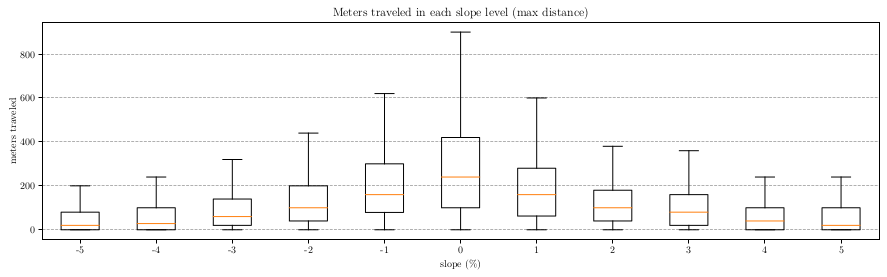

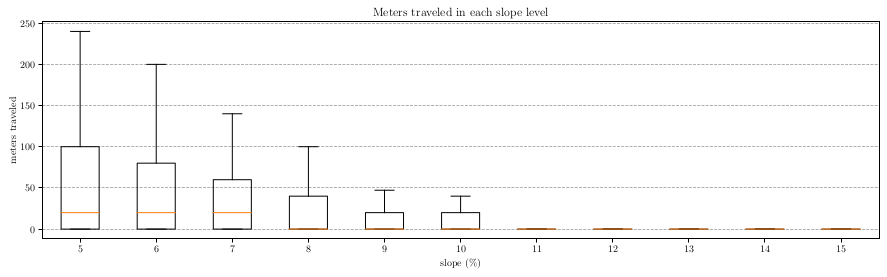

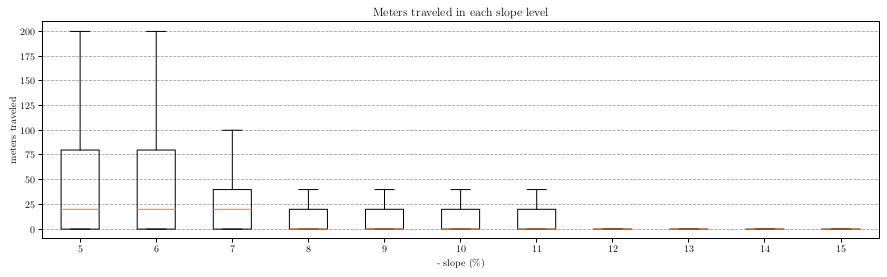

In [24]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=31, x=range(-150, 150), weights=meters_slope_mean, range=(-15, 15))
plt.title('Mean of meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,8))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope, positions=range(-15,16))
plt.title('Meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_center, positions=range(-5,6), showfliers=False)
plt.title('Meters traveled in each slope level (max distance)')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.savefig('./images/bike_trips_meters_traveled_slope_level_max_distance')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_up, positions=range(5,16), showfliers=False)
plt.title('Meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

pos = range(5,16)
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_down, positions=pos, showfliers=False)
plt.title('Meters traveled in each slope level')
plt.xlabel('- slope (%)')
plt.ylabel('meters traveled')
plt.show()

# Trip Reason

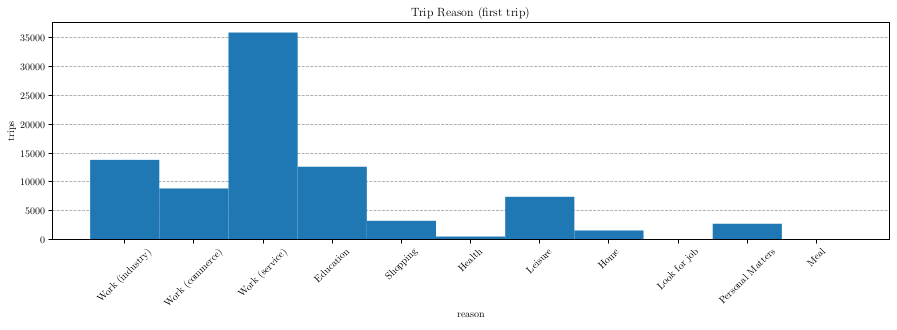

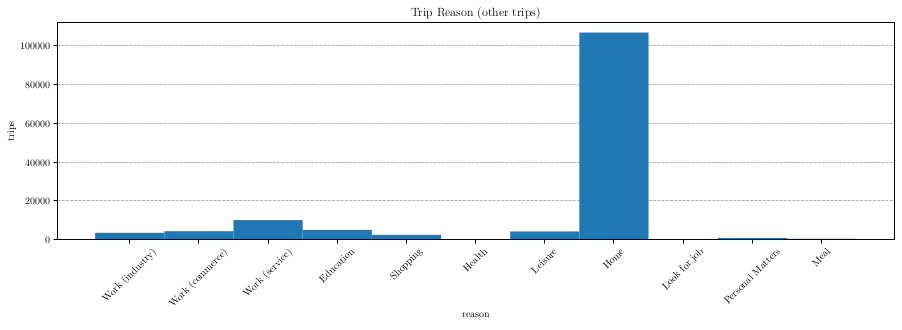

In [27]:
# Trip Reason


# 1 - Trabalho Indústria
# 2 - Trabalho Comércio
# 3 - Trabalho Serviços
# 4 - Escola/Educação
# 5 - Compras1q
# 6 - Médico/Dentista/Saúde 
# 7 - Recreação/Visitas/Lazer
# 8 - Residência
# 9 - Procurar Emprego
# 10 - Assuntos Pessoais
# 11 - Refeição

subtitle = ['Work (industry)', 'Work (commerce)', 'Work (service)',
            'Education', 'Shopping', 'Health',
            'Leisure', 'Home', 'Look for job',
            'Personal Matters', 'Meal']


plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(12)], x=od_routes_sp['MOTIVO_D'].loc[od_routes_sp['N_VIAG'] == 1], 
         weights = od_routes_sp['FE_VIA'].loc[od_routes_sp['N_VIAG'] == 1])
plt.xticks(ticks = range(1,12), labels = subtitle, rotation=45)

plt.title('Trip Reason (first trip)')
plt.xlabel('reason')
plt.ylabel('trips')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(12)], x=od_routes_sp['MOTIVO_D'].loc[od_routes_sp['N_VIAG'] > 1], 
         weights = od_routes_sp['FE_VIA'].loc[od_routes_sp['N_VIAG'] > 1])
plt.xticks(ticks = range(1,12), labels = subtitle, rotation=45)
plt.title('Trip Reason (other trips)')
plt.xlabel('reason')
plt.ylabel('trips')
plt.show()


# Week Day

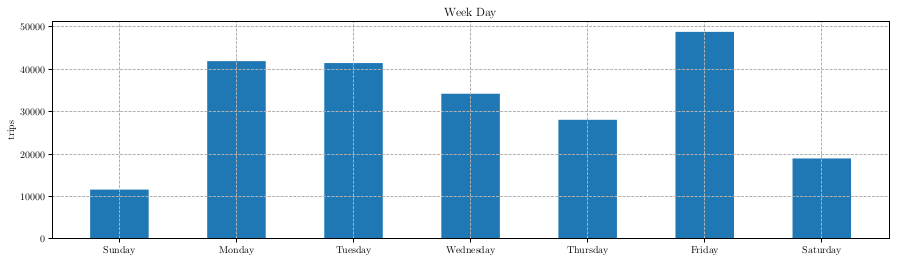

In [29]:
# Week day

plt.figure(figsize=(15,4))
plt.grid(linestyle='--')
plt.hist(x=od_routes_sp['DIASEMANA'], weights = od_routes_sp['FE_VIA'], bins=range(8), align='left', rwidth=.5)
plt.xticks(ticks = range(7), labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.title('Week Day')
plt.ylabel('trips')
plt.show()

# Day Period

10%:	 6.3
20%:	 7.3
30%:	 9.0
40%:	 12.0
50%:	 13.3
60%:	 15.3
70%:	 17.0
80%:	 18.0
90%:	 19.0
100%:	 23.3


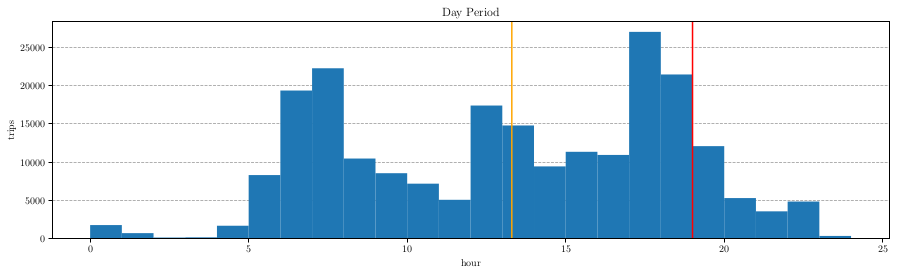

In [31]:
od_routes_sp['HORA_SAIDA_INT'] = [int(h[:2] + h[3:5]) / 100 for h in od_routes_sp['HORA_SAIDA']]
s = stats(od_routes_sp, 'HORA_SAIDA_INT')
for i in range(10):
    print(str(i + 1) + '0%:\t', round(s[i], 2))
    
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=range(25), x=od_routes_sp['HORA_SAIDA_INT'], weights = od_routes_sp['FE_VIA'])
plt.title('Day Period')
plt.xlabel('hour')
plt.ylabel('trips')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()

# People

In [32]:
od_people = od_routes_sp.groupby('ID_PESS').max()


od_people_FE_PESS = []
for i, r in od_people.iterrows():
    for w in range(round(r['FE_PESS'])):
        od_people_FE_PESS.append(r)
        
od_people_FE_PESS = pd.DataFrame(data = od_people_FE_PESS, columns = od_people.columns)


In [33]:
display(od_people_FE_PESS)

,id,ZONA,MUNI_DOM,CO_DOM_X,CO_DOM_Y,ID_DOM,F_DOM,FE_DOM,DOM,CD_ENTRE,...,PAG_VIAG,TP_ESAUTO,VL_EST,PE_BICI,VIA_BICI,TP_ESTBICI,ID_ORDEM,distance,length,HORA_SAIDA_INT
20877101,456,2,36,-23.548697,-46.629849,20877,1,68.750000,877,1,...,0,0,0.0,1,2,8,457,2.656898,2456.642964,18.1
20877101,456,2,36,-23.548697,-46.629849,20877,1,68.750000,877,1,...,0,0,0.0,1,2,8,457,2.656898,2456.642964,18.1
20877101,456,2,36,-23.548697,-46.629849,20877,1,68.750000,877,1,...,0,0,0.0,1,2,8,457,2.656898,2456.642964,18.1
20877101,456,2,36,-23.548697,-46.629849,20877,1,68.750000,877,1,...,0,0,0.0,1,2,8,457,2.656898,2456.642964,18.1
20877101,456,2,36,-23.548697,-46.629849,20877,1,68.750000,877,1,...,0,0,0.0,1,2,8,457,2.656898,2456.642964,18.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5011324101,177356,501,24,-23.507275,-46.768835,5011324,0,388.333333,1324,1,...,1,0,0.0,2,2,3,177357,17.007105,16232.282688,17.0
5011324101,177356,501,24,-23.507275,-46.768835,5011324,0,388.333333,1324,1,...,1,0,0.0,2,2,3,177357,17.007105,16232.282688,17.0
5011324101,177356,501,24,-23.507275,-46.768835,5011324,0,388.333333,1324,1,...,1,0,0.0,2,2,3,177357,17.007105,16232.282688,17.0
5011324101,177356,501,24,-23.507275,-46.768835,5011324,0,388.333333,1324,1,...,1,0,0.0,2,2,3,177357,17.007105,16232.282688,17.0


In [34]:

#distrib_weighted = dist.best_fit_distribution(od_people_FE_PESS['IDADE'], bins = 100)
#distrib_m = dist.best_fit_distribution(od_people_FE_PESS.loc[od_people_FE_PESS['SEXO'] == 1]['IDADE'], bins = 5)
#distrib_m_2 = dist.best_fit_distribution(od_people_FE_PESS.loc[od_people_FE_PESS['SEXO'] == 1]['IDADE'], bins = 20)
#distrib_f = dist.best_fit_distribution(od_people_FE_PESS.loc[od_people_FE_PESS['SEXO'] == 2]['IDADE'], bins = 5)
#print(distrib_m)
#print(distrib_m_2)
#print(distrib_f)
# bins=100
#('gausshyper', (5.279282420419191, 9.427435120845999, 1.7042238760442698, -0.6290314796750072, -9.35105798112198, 113.89907371835868))
#('dgamma', (0.39638728719946925, 29.000000000000007, 9.770561148311165))

#('gausshyper', (5.279282420419191, 9.427435120845999, 1.7042238760442698, -0.6290314796750072, -9.35105798112198, 113.89907371835868))
#('dweibull', (0.7423596624388107, 28.999999999999993, 8.493736966849728))

#('johnsonsb', (0.8055797096186554, 2.1136560472330137, -19.37982613926068, 130.04829427120896))
#('gennorm', (0.3515821692724699, 29.0, 0.20540942031825238))

#('foldcauchy', (6.114613850953486, 0.9999999626040696, 4.4346970738639975))

#distrib_weighted = dist.best_fit_distribution(od_people_FE_PESS['IDADE'], bins = 25)
#print(distrib_weighted)
#genextreme', (0.195561684562034, 27.800891741589794, 13.381742809374167))

# ambas com 5 bins:
#masc ('gausshyper', (5.279282420419191, 9.427435120845999, 1.7042238760442698, -0.6290314796750072, -9.35105798112198, 113.89907371835868))
#fem: ('loggamma', (897.3569843061273, -2332.923603808461, 347.1732584129129))


# Age

Age  10%:	 17
Age  20%:	 20
Age  30%:	 25
Age  40%:	 30
Age  50%:	 33
Age  60%:	 36
Age  70%:	 41
Age  80%:	 47
Age  90%:	 52
Age  100%:	 81


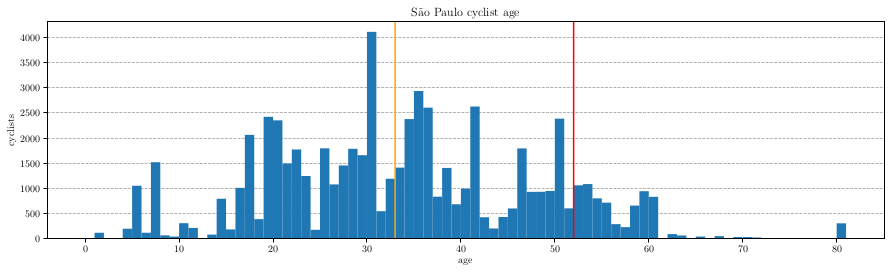

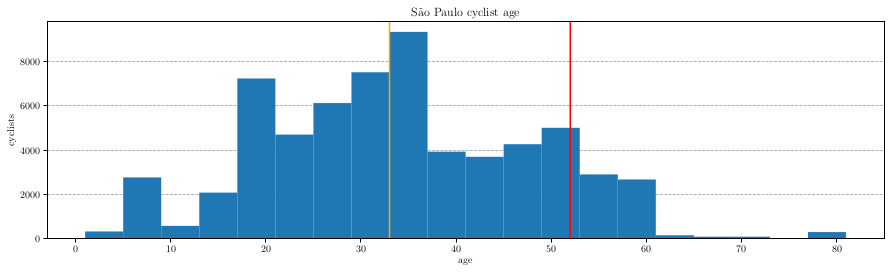

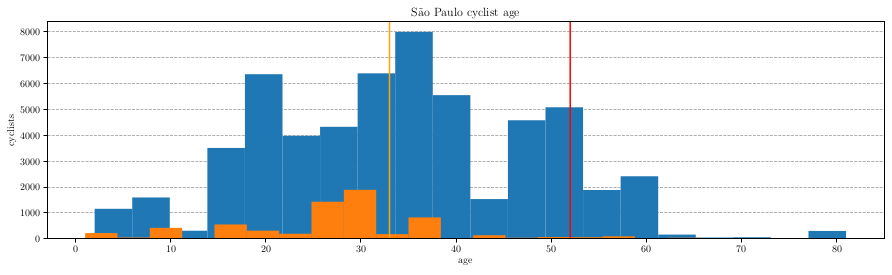

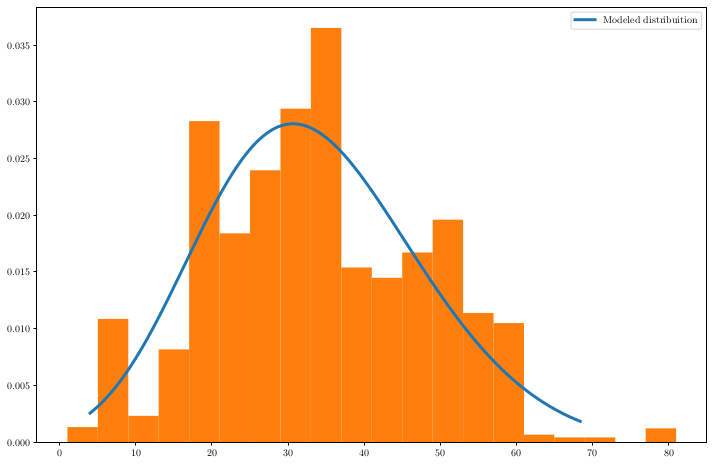

In [37]:
import scipy.stats as st
#display(distrib_weighted)
s = stats(od_people, 'IDADE', 'FE_PESS')
for i in range(10):
    print('Age  ' + str(i + 1) + '0%:\t', round(s[i]))
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = range(82), x=od_people['IDADE'], weights = od_people['FE_PESS'])
plt.title('São Paulo cyclist age')
plt.xlabel('age')
plt.ylabel('cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()   

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = 20, x=od_people['IDADE'], weights = od_people['FE_PESS'])
plt.title('São Paulo cyclist age')
plt.xlabel('age')
plt.ylabel('cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = 20, x=od_people.loc[od_people['SEXO'] == 1]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 1]['FE_PESS'])
plt.hist(bins = 20, x=od_people.loc[od_people['SEXO'] == 2]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 2]['FE_PESS'])
plt.title('São Paulo cyclist age')
plt.xlabel('age')
plt.ylabel('cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()

distance_pdf = dist.make_pdf(st.genextreme, (0.195561684562034, 27.800891741589794, 13.381742809374167))
plt.figure(figsize=(12,8))
ax = distance_pdf.plot(lw=3, label='Modeled distribuition', legend=True)
plt.hist(bins = 20, x=od_people['IDADE'], weights = od_people['FE_PESS'], density=True)
plt.show()

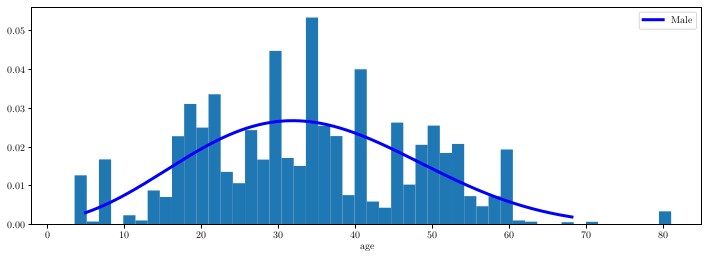

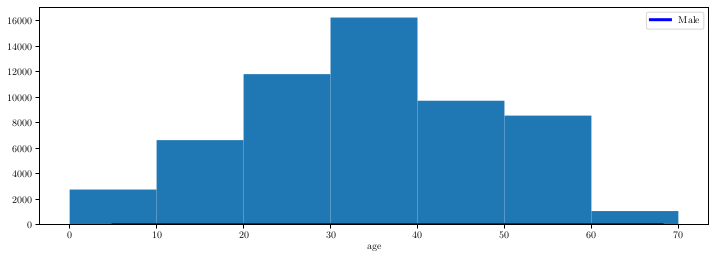

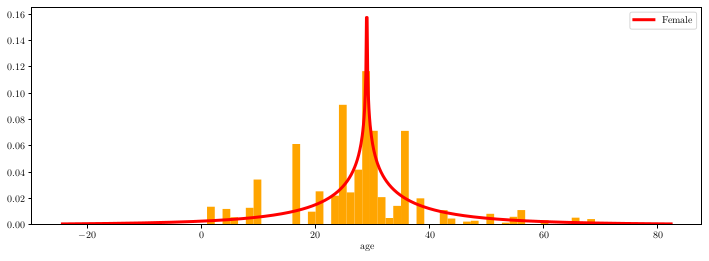

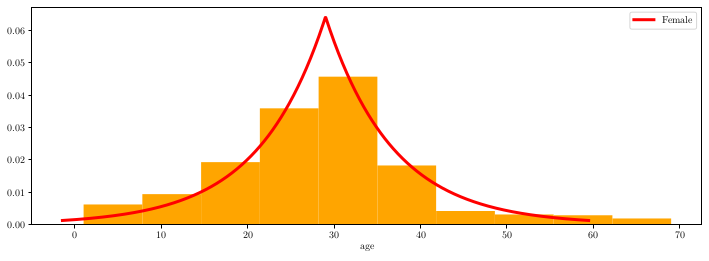

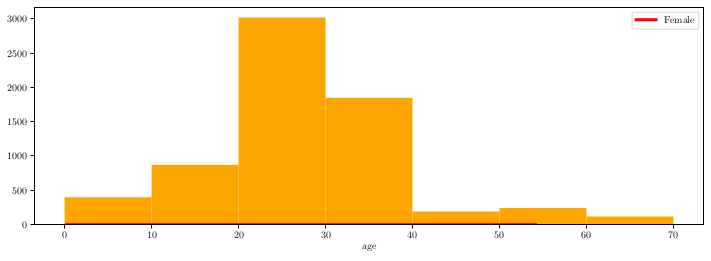

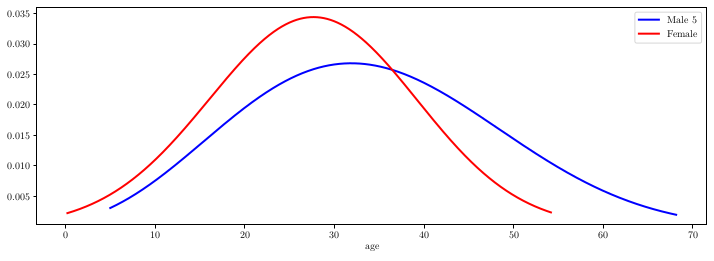

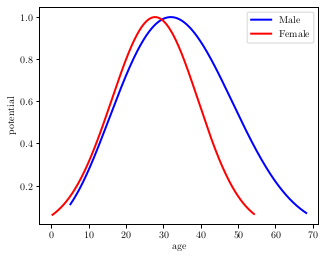

In [38]:
# m 5 ('gausshyper', (5.279282420419191, 9.427435120845999, 1.7042238760442698, -0.6290314796750072, -9.35105798112198, 113.89907371835868))
# f 5 ('loggamma', (897.3569843061273, -2332.923603808461, 347.1732584129129))
# m 20 ('johnsonsb', (0.8055797096186554, 2.1136560472330137, -19.37982613926068, 130.04829427120896))

age_pdf_m = dist.make_pdf(st.gausshyper, (5.279282420419191, 9.427435120845999, 1.7042238760442698, -0.6290314796750072, -9.35105798112198, 113.89907371835868))
age_pdf_f = dist.make_pdf(st.dweibull, (0.7423596624388107, 28.999999999999993, 8.493736966849728))
plt.figure(figsize=(12,4))
plt.hist(bins = 50, x=od_people.loc[od_people['SEXO'] == 1]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 1]['FE_PESS'], density=True)
ax = age_pdf_m.plot(lw=3, label='Male', legend=True, color='blue')
plt.xlabel('age')
plt.show()

plt.figure(figsize=(12,4))
plt.hist(bins = range(0, 80, 10), x = od_people.loc[od_people['SEXO'] == 1]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 1]['FE_PESS'], density=False)
ax = age_pdf_m.plot(lw=3, label='Male', legend=True, color='blue')
plt.xlabel('age')
plt.show()

plt.figure(figsize=(12,4))
plt.hist(bins = 50, x=od_people.loc[od_people['SEXO'] == 2]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 2]['FE_PESS'], density=True, color = 'orange')
ax = age_pdf_f.plot(lw=3, label='Female', legend=True, color='red')
plt.xlabel('age')
plt.show()

age_pdf_f = dist.make_pdf(st.laplace, (29.0, 7.783973688144715))
plt.figure(figsize=(12,4))
plt.hist(bins = 10, x=od_people.loc[od_people['SEXO'] == 2]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 2]['FE_PESS'], density=True, color = 'orange')
ax = age_pdf_f.plot(lw=3, label='Female', legend=True, color='red')
plt.xlabel('age')
plt.show()

age_pdf_f = dist.make_pdf(st.loggamma, (897.3569843061273, -2332.923603808461, 347.1732584129129))
plt.figure(figsize=(12,4))
plt.hist(bins = range(0, 80, 10), x=od_people.loc[od_people['SEXO'] == 2]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 2]['FE_PESS'], density=False, color = 'orange')
ax = age_pdf_f.plot(lw=3, label='Female', legend=True, color='red')
plt.xlabel('age')
plt.show()

plt.figure(figsize=(12,4))
ax = age_pdf_m.plot(lw=2, label='Male 5', legend=True, color='blue')
ax = age_pdf_f.plot(lw=2, label='Female', legend=True, color='red')
plt.xlabel('age')
plt.show()

max_m = max(d for d in age_pdf_m)
max_f = max(d for d in age_pdf_f)
age_m_scaled = age_pdf_m / max_m
age_f_scaled = age_pdf_f / max_f

plt.figure(figsize=(5,4))
ax = age_m_scaled.plot(lw=2, label='Male', legend=True, color='blue')
ax = age_f_scaled.plot(lw=2, label='Female', legend=True, color='red')
plt.xlabel('age')
plt.ylabel('potential')
plt.show()


# Car Ownership

Cars quantity  10%:	 0.0
Cars quantity  20%:	 0.0
Cars quantity  30%:	 0.0
Cars quantity  40%:	 0.0
Cars quantity  50%:	 0.2
Cars quantity  60%:	 0.25
Cars quantity  70%:	 0.33
Cars quantity  80%:	 0.4
Cars quantity  90%:	 0.5
Cars quantity  100%:	 2.0


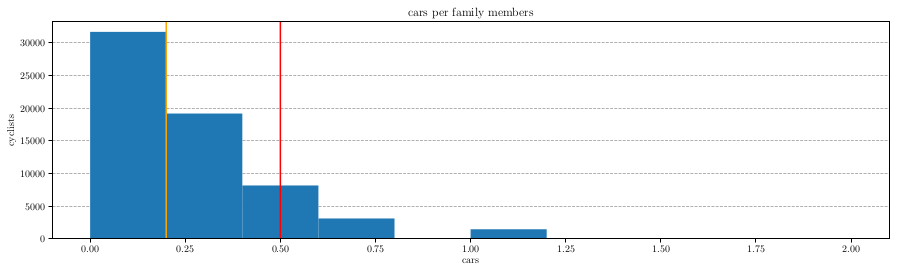

In [40]:
od_people['CARS_PER_FAMILY'] = od_people['QT_AUTO'] / od_people['NO_MORAF']
s = stats(od_people, 'CARS_PER_FAMILY', 'FE_PESS')
for i in range(10):
    print('Cars quantity  ' + str(i + 1) + '0%:\t', round(s[i], 2))
    
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=10, x=od_people['CARS_PER_FAMILY'], weights = od_people['FE_PESS'])
plt.title('cars per family members')
plt.xlabel('cars')
plt.ylabel('cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.savefig('./images/bike_trips_cars_per_family_members')
plt.show()

# Economic Classification

10%:	 1
20%:	 2
30%:	 3
40%:	 3
50%:	 4
60%:	 4
70%:	 4
80%:	 5
90%:	 6
100%:	 6


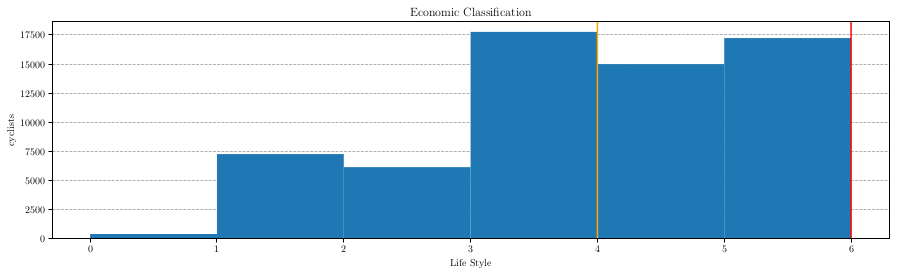

In [41]:
s = stats(od_people, 'CRITERIOBR', 'FE_PESS')
for i in range(10):
    print(str(i + 1) + '0%:\t', round(s[i]))
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = range(7), x=od_people['CRITERIOBR'], weights = od_people['FE_PESS'])
plt.title('Economic Classification')
plt.xlabel('Life Style')
plt.ylabel('cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.savefig('./images/bike_trips_economic_classification')
plt.show()   

# 1 - A
# 2 - B1
# 3 - B2
# 4 - C1
# 5 - C2
# 6 - D - E


10%:	 0
20%:	 0
30%:	 0
40%:	 0
50%:	 0
60%:	 1200
70%:	 1500
80%:	 2000
90%:	 3200
100%:	 20000
10%:	 425
20%:	 550
30%:	 683
40%:	 900
50%:	 1130
60%:	 1350
70%:	 1793
80%:	 2345
90%:	 3709
100%:	 20000
10%:	 1
20%:	 1
30%:	 1
40%:	 1
50%:	 1
60%:	 2
70%:	 3
80%:	 3
90%:	 3
100%:	 6


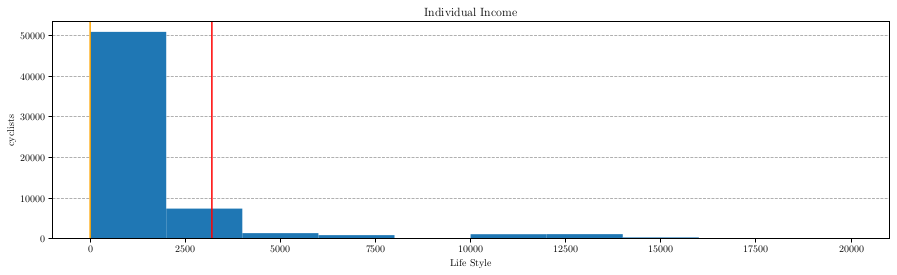

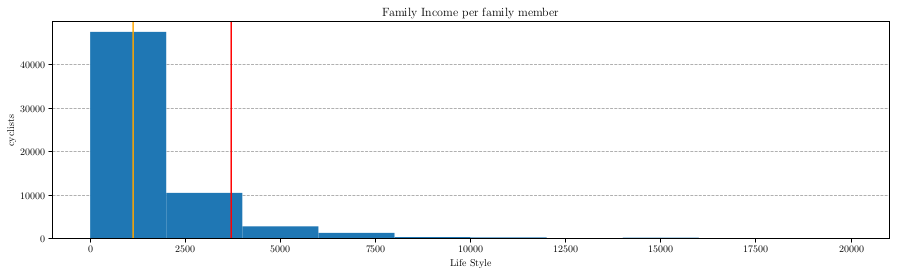

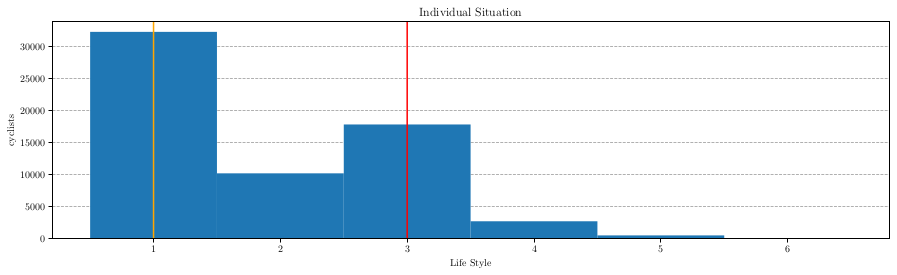

In [42]:
s = stats(od_people, 'VL_REN_I', 'FE_PESS')
for i in range(10):
    print(str(i + 1) + '0%:\t', round(s[i]))
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(x=od_people['VL_REN_I'], weights = od_people['FE_PESS'])
plt.title('Individual Income')
plt.xlabel('Life Style')
plt.ylabel('cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.savefig('./images/individual_income')
plt.show()   

od_people['mean_income'] = od_people['RENDA_FA'] / od_people['NO_MORAF']
s = stats(od_people, 'mean_income', 'FE_PESS')
for i in range(10):
    print(str(i + 1) + '0%:\t', round(s[i]))
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(x=od_people['mean_income'], weights = od_people['FE_PESS'])
plt.title('Family Income per family member')
plt.xlabel('Life Style')
plt.ylabel('cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()   

s = stats(od_people, 'SIT_FAM', 'FE_PESS')
for i in range(10):
    print(str(i + 1) + '0%:\t', round(s[i]))
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(7)], x=od_people['SIT_FAM'], weights = od_people['FE_PESS'])
plt.title('Individual Situation')
plt.xlabel('Life Style')
plt.ylabel('cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()   

# 1 - Pessoa Responsável
# 2 - Cônjuge/Companheiro(a)
# 3 - Filho(a)/Enteado(a)
# 4 - Outro Parente
# 5 - Agregado
# 6 - Empregado Residente
# 7 - Parente do Empregado Residente

# Education

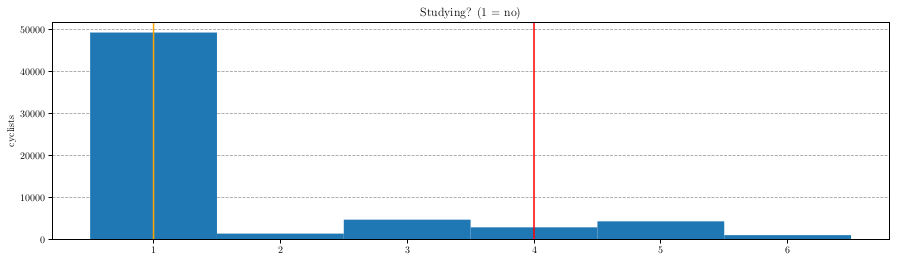

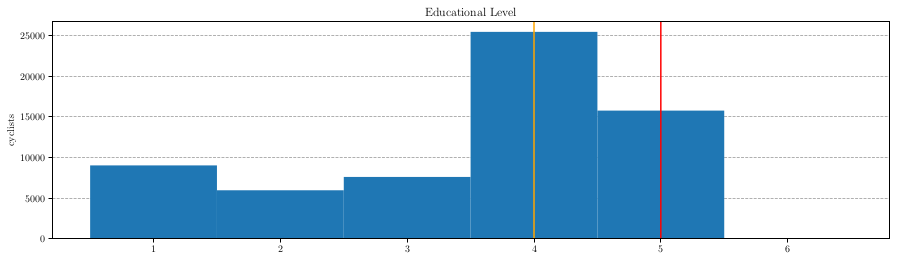

In [44]:
s = stats(od_people, 'ESTUDA', 'FE_PESS')
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(7)], x=od_people['ESTUDA'], weights = od_people['FE_PESS'])
plt.title('Studying? (1 = no)')
plt.ylabel('cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()   

s = stats(od_people, 'GRAU_INS', 'FE_PESS')
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(7)], x=od_people['GRAU_INS'], weights = od_people['FE_PESS'])
plt.title('Educational Level')
plt.ylabel('cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()   

#1 - Não-Alfabetizado/Fundamental I Incompleto
#2 - Fundamental I Completo/Fundamental II Incompleto
#3 - Fundamental II Completo/Médio Incompleto
#4 - Médio Completo/Superior Incompleto
#5 - Superior Completog


# Number of trips

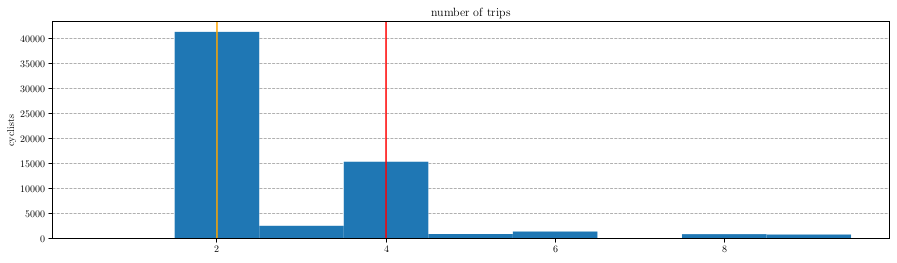

In [45]:
s = stats(od_people, 'TOT_VIAG', 'FE_PESS')
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(10)], x=od_people['TOT_VIAG'], weights = od_people['FE_PESS'])
plt.title('number of trips')
plt.ylabel('cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.savefig('./images/bike_trips_number_of_trips')
plt.show()   

### All People (not only cyclists)

In [46]:
od_trips = pd.read_csv('../data/sao-paulo/od/OD_2017.csv')
od_trips.columns = [c[: c.index(',')] for c in od_trips.columns]
od_trips.set_index('ID_ORDEM', inplace=True, drop=False)

od_people = od_trips.loc[od_trips['MODOPRIN'] == 15].groupby('ID_PESS').max()

od_people_FE_PESS = []
for i, r in od_people.iterrows():
    for w in range(round(r['FE_PESS'])):
        od_people_FE_PESS.append(r)
        
od_people_FE_PESS = pd.DataFrame(data = od_people_FE_PESS, columns = od_people.columns)

In [47]:
display(od_people_FE_PESS)
od_bike_trips = od_trips.loc[od_trips['MODOPRIN'] == 15]
display(od_bike_trips)
display(sum(od_bike_trips['FE_VIA']))

,ZONA,MUNI_DOM,CO_DOM_X,CO_DOM_Y,ID_DOM,F_DOM,FE_DOM,DOM,CD_ENTRE,DATA,...,DURACAO,MODOPRIN,TIPVG,PAG_VIAG,TP_ESAUTO,VL_EST,PE_BICI,VIA_BICI,TP_ESTBICI,ID_ORDEM
20877101,2.0,36.0,333638.0,7394792.0,20877.0,1.0,68.750000,877.0,1.0,2082018.0,...,10.0,15.0,4.0,0.0,0.0,0.0,1.0,2.0,8.0,457.0
20877101,2.0,36.0,333638.0,7394792.0,20877.0,1.0,68.750000,877.0,1.0,2082018.0,...,10.0,15.0,4.0,0.0,0.0,0.0,1.0,2.0,8.0,457.0
20877101,2.0,36.0,333638.0,7394792.0,20877.0,1.0,68.750000,877.0,1.0,2082018.0,...,10.0,15.0,4.0,0.0,0.0,0.0,1.0,2.0,8.0,457.0
20877101,2.0,36.0,333638.0,7394792.0,20877.0,1.0,68.750000,877.0,1.0,2082018.0,...,10.0,15.0,4.0,0.0,0.0,0.0,1.0,2.0,8.0,457.0
20877101,2.0,36.0,333638.0,7394792.0,20877.0,1.0,68.750000,877.0,1.0,2082018.0,...,10.0,15.0,4.0,0.0,0.0,0.0,1.0,2.0,8.0,457.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5162821103,516.0,31.0,312175.0,7402685.0,5162821.0,0.0,291.658537,2821.0,1.0,6102018.0,...,15.0,15.0,4.0,0.0,0.0,0.0,1.0,2.0,1.0,182653.0
5162821103,516.0,31.0,312175.0,7402685.0,5162821.0,0.0,291.658537,2821.0,1.0,6102018.0,...,15.0,15.0,4.0,0.0,0.0,0.0,1.0,2.0,1.0,182653.0
5162821103,516.0,31.0,312175.0,7402685.0,5162821.0,0.0,291.658537,2821.0,1.0,6102018.0,...,15.0,15.0,4.0,0.0,0.0,0.0,1.0,2.0,1.0,182653.0
5162821103,516.0,31.0,312175.0,7402685.0,5162821.0,0.0,291.658537,2821.0,1.0,6102018.0,...,15.0,15.0,4.0,0.0,0.0,0.0,1.0,2.0,1.0,182653.0


,ZONA,MUNI_DOM,CO_DOM_X,CO_DOM_Y,ID_DOM,F_DOM,FE_DOM,DOM,CD_ENTRE,DATA,...,DURACAO,MODOPRIN,TIPVG,PAG_VIAG,TP_ESAUTO,VL_EST,PE_BICI,VIA_BICI,TP_ESTBICI,ID_ORDEM
ID_ORDEM,,,,,,,,,,,,,,,,,,,,,
450,2,36,333638,7394792,20877,1,68.750000,877,1,2082018,...,10,15,4,0,0,0.0,1,2,8,450
451,2,36,333638,7394792,20877,0,68.750000,877,1,2082018,...,10,15,4,0,0,0.0,1,2,3,451
452,2,36,333638,7394792,20877,0,68.750000,877,1,2082018,...,10,15,4,0,0,0.0,1,2,8,452
453,2,36,333638,7394792,20877,0,68.750000,877,1,2082018,...,10,15,4,0,0,0.0,1,2,3,453
454,2,36,333638,7394792,20877,0,68.750000,877,1,2082018,...,10,15,4,0,0,0.0,1,2,8,454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181110,513,17,297051,7391506,5130534,0,76.700000,534,1,23062018,...,60,15,4,0,0,0.0,4,2,3,181110
181997,515,17,301914,7392584,5150582,0,401.953543,582,1,4052018,...,15,15,4,0,0,0.0,1,2,3,181997
181998,515,17,301914,7392584,5150582,0,401.953543,582,1,4052018,...,25,15,4,0,0,0.0,1,2,3,181998


376975.23400600004

Age  10%:	 17
Age  20%:	 20
Age  30%:	 24
Age  40%:	 29
Age  50%:	 34
Age  60%:	 37
Age  70%:	 42
Age  80%:	 48
Age  90%:	 53
Age  100%:	 81


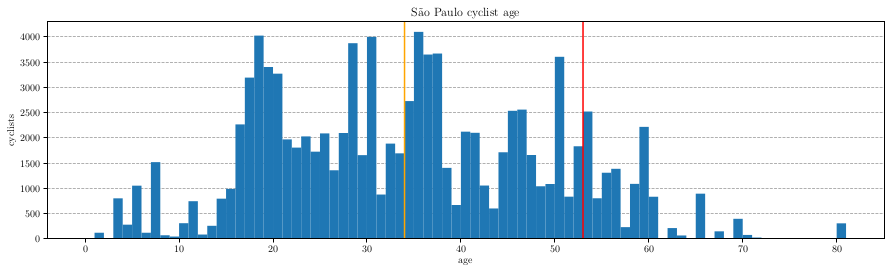

In [48]:
s = stats(od_people, 'IDADE', 'FE_PESS')
for i in range(10):
    print('Age  ' + str(i + 1) + '0%:\t', round(s[i]))
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = range(82), x=od_people['IDADE'], weights = od_people['FE_PESS'])
plt.title('São Paulo cyclist age')
plt.xlabel('age')
plt.ylabel('cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()   

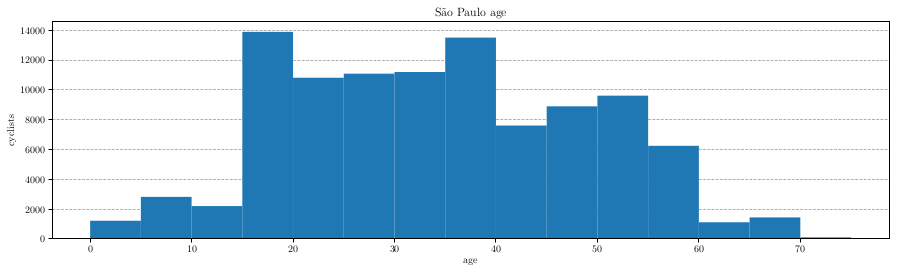

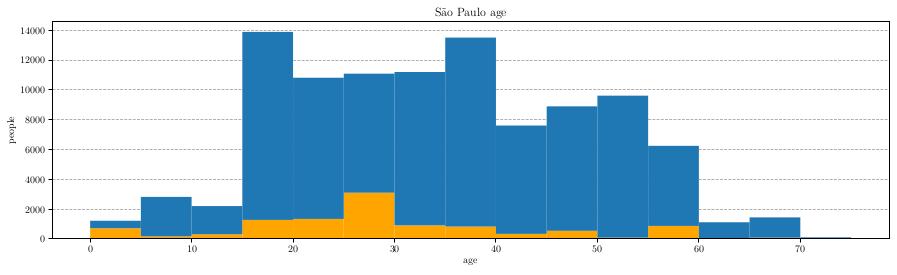

In [50]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = range(0,80,5), x=od_people['IDADE'], weights = od_people['FE_PESS'])
plt.title('São Paulo age')
plt.xlabel('age')
plt.ylabel('cyclists')
plt.show()   

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(
    bins = range(0, 80, 5), 
    x = [od_people.loc[od_people['SEXO'] == 2]['IDADE'], od_people.loc[od_people['SEXO'] == 1]['IDADE']],
    weights = [od_people.loc[od_people['SEXO'] == 2]['FE_PESS'], od_people.loc[od_people['SEXO'] == 1]['FE_PESS']],
    label = ['Male', 'Female'],
    color = ['orange', '#1f77b4'],
    histtype = 'barstacked')
plt.title('São Paulo age')
plt.xlabel('age')
plt.ylabel('people')
plt.show()    

In [51]:
display(sum(od_people['FE_PESS']))

for s in [1, 2]:
    age = 0
    while age <= 85:
        cyclists = sum(od_people.loc[od_people['SEXO'] == s].loc[od_people['IDADE'] >= age].loc[od_people['IDADE'] < age + 5]['FE_PESS'])
        #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
        print('(' + str(age + 2.5) + ', ' + str(cyclists / 1000) + ')')
        age += 5
    print ('-------------------')


102069.09576200003

(2.5, 0.501420584)
(7.5, 2.6494282850000004)
(12.5, 1.8943469569999998)
(17.5, 12.607775791000003)
(22.5, 9.466103854)
(27.5, 7.981424106999999)
(32.5, 10.283835427999996)
(37.5, 12.671488578999998)
(42.5, 7.2632337819999995)
(47.5, 8.345315259000001)
(52.5, 9.520872378)
(57.5, 5.3709647160000005)
(62.5, 1.0908688439999998)
(67.5, 1.3606188650000002)
(72.5, 0.10788381699999999)
(77.5, 0.0)
(82.5, 0.30986187)
(87.5, 0.0)
-------------------
(2.5, 0.719980221)
(7.5, 0.17180107)
(12.5, 0.312377205)
(17.5, 1.2779697)
(22.5, 1.345162097)
(27.5, 3.1025182829999998)
(32.5, 0.9117382970000001)
(37.5, 0.8313856859999998)
(42.5, 0.34219680199999997)
(47.5, 0.547539136)
(52.5, 0.088477897)
(57.5, 0.874909263)
(62.5, 0.030770913)
(67.5, 0.086826076)
(72.5, 0.0)
(77.5, 0.0)
(82.5, 0.0)
(87.5, 0.0)
-------------------


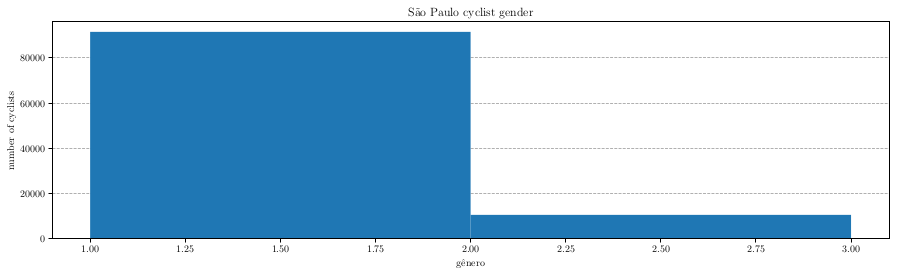

In [52]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = [1,2,3], x=od_people['SEXO'], weights = od_people['FE_PESS'])
plt.title('São Paulo cyclist gender')
plt.xlabel('gênero')
plt.ylabel('number of cyclists')
#plt.axvline(x=s[4],color='orange')
#plt.axvline(x=s[8],color='red')
plt.show()   

In [53]:
print(sum(od_people.loc[od_people['SEXO'] == 1]['FE_PESS']))
print(sum(od_people.loc[od_people['SEXO'] == 2]['FE_PESS']))

91425.44311600002
10643.652645999999


In [54]:
print(sum(od_people['FE_PESS']))
print(sum(od_people.loc[od_people['ESTUDA'] == 1]['FE_PESS']))
print(sum(od_people.loc[od_people['GRAU_INS'] < 4]['FE_PESS']))
print(sum(od_people.loc[od_people['GRAU_INS'] ==4]['FE_PESS']))
print(sum(od_people.loc[od_people['GRAU_INS'] ==5]['FE_PESS']))

102069.09576200003
81470.13647200003
45403.84891300001
41308.880197
15356.366651999999


0.0
0.0
0.0
0.0
0.0
1000.0
1200.0
1500.0
2000.0
20000.0
10%:	 316
20%:	 494
30%:	 624
40%:	 767
50%:	 967
60%:	 1130
70%:	 1400
80%:	 1800
90%:	 2667
100%:	 20000


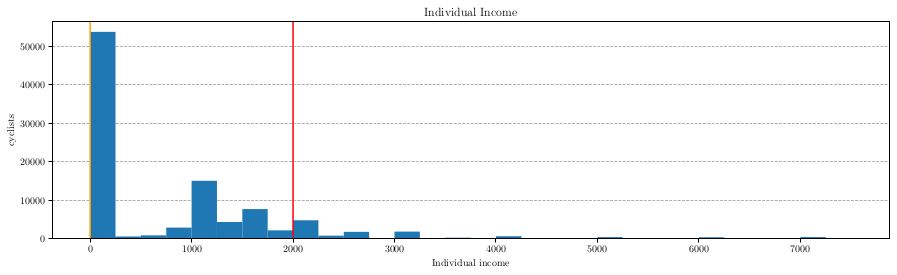

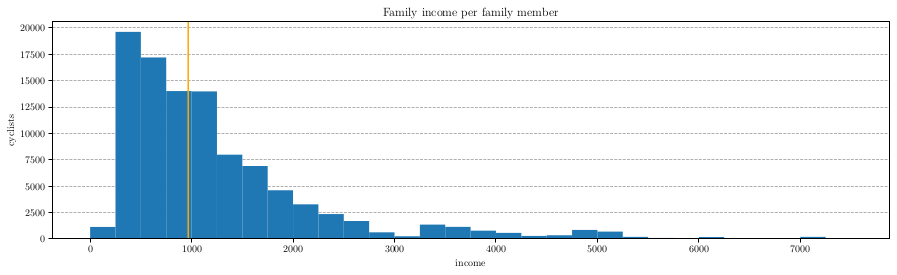

In [57]:
s = stats(od_people, 'VL_REN_I', 'FE_PESS')
for i in s:
    print(i)

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = 30, x = od_people['VL_REN_I'], weights = od_people['FE_PESS'], range=(0,7500))
plt.title('Individual Income')
plt.xlabel('Individual income')
plt.ylabel('cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.savefig('./images/individual_income')
plt.show()   



od_people['mean_income'] = od_people['RENDA_FA'] / od_people['NO_MORAF']
s = stats(od_people, 'mean_income', 'FE_PESS')
for i in range(10):
    print(str(i + 1) + '0%:\t', round(s[i]))
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = 30,x=od_people['mean_income'], weights = od_people['FE_PESS'], range=(0,7500))
plt.title('Family income per family member')
plt.xlabel('income')
plt.ylabel('cyclists')
plt.axvline(x=s[4],color='orange')
#plt.axvline(x=s[8],color='red')
plt.show() 

In [58]:
display(sum(od_people['FE_PESS']))

income = 0
while income <= 6000:
    cyclists = sum(od_people.loc[od_people['mean_income'] >= income]
                   .loc[od_people['mean_income'] < income + 200]['FE_PESS'])
    #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
    print('(' + str(income + 100) + ', ' + str(cyclists / 1000) + ')')
    income += 200

102069.09576200003

(100, 0.512710503)
(300, 14.124325831999998)
(500, 14.181447151000004)
(700, 13.451961343)
(900, 9.693631821999999)
(1100, 11.314953286)
(1300, 6.744038764000001)
(1500, 5.414034792000001)
(1700, 6.201919408000001)
(1900, 3.814942969)
(2100, 1.901695548)
(2300, 3.5357713260000008)
(2500, 0.601987755)
(2700, 1.6102952890000002)
(2900, 0.32249289500000006)
(3100, 0.20345585800000002)
(3300, 1.172412526)
(3500, 1.227402401)
(3700, 0.335587491)
(3900, 0.608369001)
(4100, 0.553638259)
(4300, 0.06277994099999999)
(4500, 0.28263227500000004)
(4700, 0.52149752)
(4900, 0.6548148220000001)
(5100, 0.699539268)
(5300, 0.196556396)
(5500, 0.048444041)
(5700, 0.051266711)
(5900, 0.091757982)
(6100, 0.185309794)


In [59]:
print(sum(od_people['FE_PESS']))
od_people['cars_per_capita'] =  od_people['QT_AUTO'] / od_people['NO_MORAF']
print(sum(od_people.loc[od_people['QT_AUTO'] == 0]['FE_PESS']))
print(sum(od_people.loc[od_people['QT_AUTO'] >= 1]['FE_PESS']))

102069.09576200003
58434.561057
43634.53470499999


ID_PESS
20877101      0.0
20877102      0.0
20877103      0.0
41216101      0.0
41230101      0.0
             ... 
5060023101    0.0
5110030101    0.0
5130534101    0.0
5150582103    0.0
5162821103    2.0
Name: members_per_car, Length: 566, dtype: float64

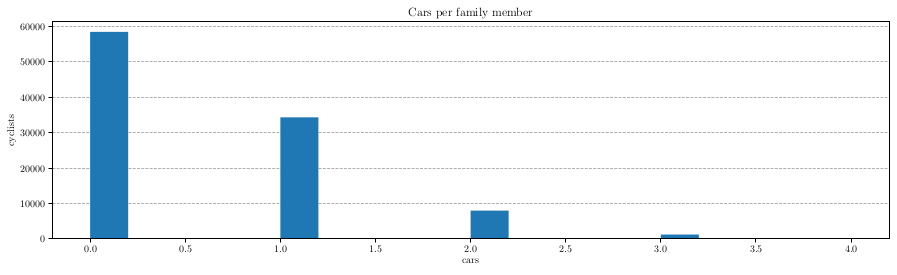

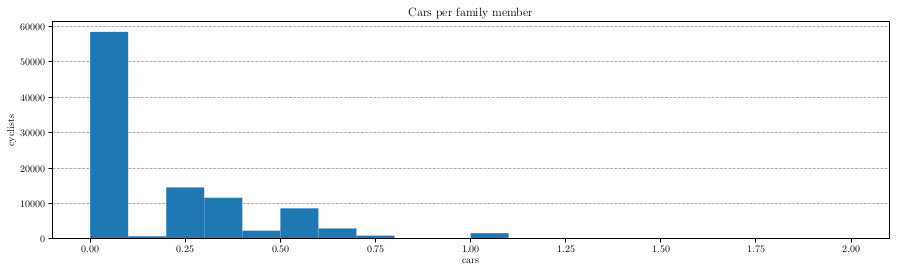

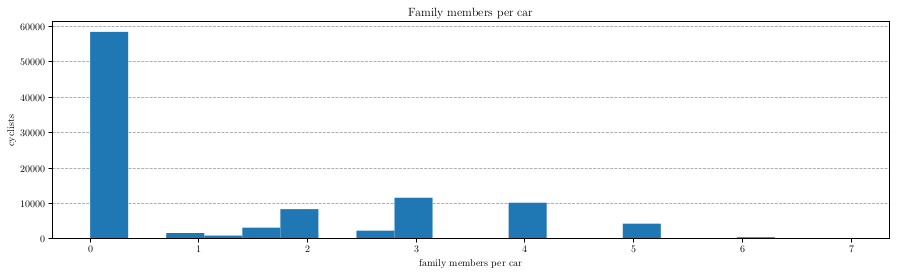

In [60]:
od_people['cars_per_capita'] =  od_people['QT_AUTO'] / od_people['NO_MORAF']

od_people['members_per_car'] = [0 if r['QT_AUTO'] == 0 else r['NO_MORAF'] / r['QT_AUTO'] 
                                for _, r in od_people.iterrows()]

display(od_people['members_per_car'])

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=od_people['QT_AUTO'], weights = od_people['FE_PESS'])
plt.title('Cars per family member')
plt.xlabel('cars')
plt.ylabel('cyclists')
#plt.axvline(x=s[4],color='orange')
#plt.axvline(x=s[8],color='red')
plt.show() 

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=od_people['cars_per_capita'], weights = od_people['FE_PESS'])
plt.title('Cars per family member')
plt.xlabel('cars')
plt.ylabel('cyclists')
#plt.axvline(x=s[4],color='orange')
#plt.axvline(x=s[8],color='red')
plt.show() 


plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=od_people['members_per_car'], weights = od_people['FE_PESS'])
plt.title('Family members per car')
plt.xlabel('family members per car')
plt.ylabel('cyclists')
#plt.axvline(x=s[4],color='orange')
#plt.axvline(x=s[8],color='red')
plt.show() 


In [61]:
print(sum(od_people.loc[od_people['members_per_car'] > 2]['FE_PESS']))

display(sum(od_people['FE_PESS']))

member = 0
while member <= 10:
    cyclists = sum(od_people.loc[od_people['QT_AUTO'] >= 1]
                            .loc[od_people['members_per_car'] >= member]
                   .loc[od_people['members_per_car'] < member + 1]['FE_PESS'])
    #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
    print('(' + str(member) + ', ' + str(cyclists / 1000) + ')')
    member += 1
    

member = 0
while member <= 10:
    cyclists = sum(od_people.loc[od_people['QT_AUTO'] >= member]
                   .loc[od_people['QT_AUTO'] < member + 1]['FE_PESS'])
    #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
    print('(' + str(member) + ', ' + str(cyclists / 1000) + ')')
    member += 1

29300.349467999993


102069.09576200003

(0, 0.132795251)
(1, 5.787282989000001)
(2, 10.761665375999998)
(3, 11.641630450000001)
(4, 10.234060259)
(5, 4.317643795)
(6, 0.502678609)
(7, 0.256777976)
(8, 0.0)
(9, 0.0)
(10, 0.0)
(0, 58.434561056999996)
(1, 34.315169647999994)
(2, 8.009519319999999)
(3, 1.258569008)
(4, 0.051276729)
(5, 0.0)
(6, 0.0)
(7, 0.0)
(8, 0.0)
(9, 0.0)
(10, 0.0)


### Trips Stats

In [62]:
od_bike_trips = od_trips.loc[od_trips['MODOPRIN'] == 15]

In [63]:
print(sum(od_bike_trips['FE_VIA']))

376975.23400600004


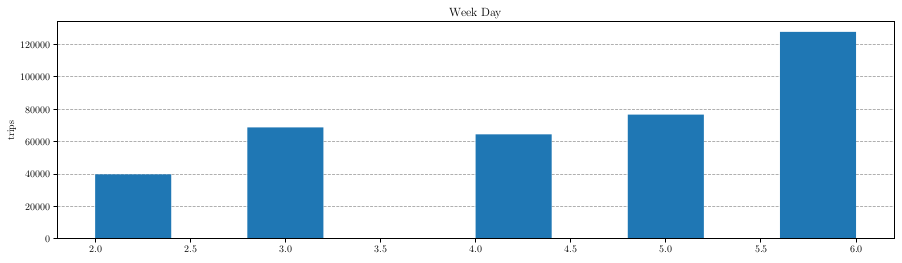

In [65]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist( x=od_bike_trips['DIA_SEM'], weights = od_bike_trips['FE_VIA'])
plt.title('Week Day')
plt.ylabel('trips')
plt.show()

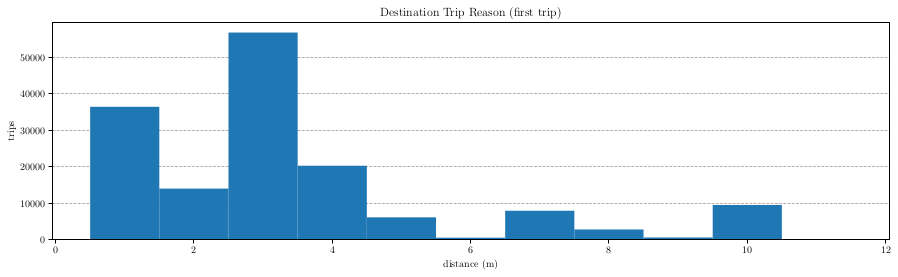

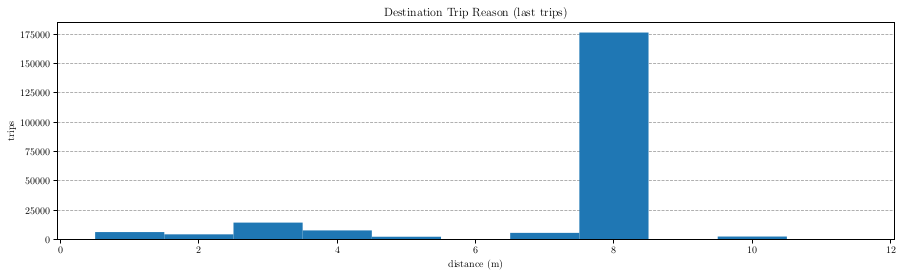

In [68]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(12)], x=od_bike_trips['MOTIVO_D'].loc[od_bike_trips['N_VIAG'] == 1], weights = od_bike_trips['FE_VIA'].loc[od_bike_trips['N_VIAG'] == 1])
plt.title('Destination Trip Reason (first trip)')
plt.xlabel('distance (m)')
plt.ylabel('trips')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(12)], x=od_bike_trips['MOTIVO_D'].loc[od_bike_trips['N_VIAG'] > 1], weights = od_bike_trips['FE_VIA'].loc[od_bike_trips['N_VIAG'] > 1])
plt.title('Destination Trip Reason (last trips)')
plt.xlabel('distance (m)')
plt.ylabel('trips')
plt.show()

# 1 - Trabalho Indústria
# 2 - Trabalho Comércio
# 3 - Trabalho Serviços
# 4 - Escola/Educação
# 5 - Compras1q
# 6 - Médico/Dentista/Saúde 
# 7 - Recreação/Visitas/Lazer
# 8 - Residência
# 9 - Procurar Emprego
# 10 - Assuntos Pessoais
# 11 - Refeição

In [69]:
print(sum(od_bike_trips.loc[od_bike_trips['N_VIAG'] <= 1]['FE_VIA']))
print(sum(od_bike_trips.loc[od_bike_trips['N_VIAG'] > 1]['FE_VIA']))

x = 0 #dado para contar
while x <= 11:
    cyclists = sum(od_bike_trips.loc[od_bike_trips['MOTIVO_D'] == x]
                   .loc[od_bike_trips['N_VIAG'] == 1]['FE_VIA'])
    #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
    print('(' + str(x) + ', ' + str(cyclists / 1000) + ')')
    x += 1
x = 0 #dado para contar
while x <= 11:
    cyclists = sum(od_bike_trips.loc[od_bike_trips['MOTIVO_D'] == x]
                   .loc[od_bike_trips['N_VIAG'] > 1]['FE_VIA'])
    #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
    print('(' + str(x) + ', ' + str(cyclists / 1000) + ')')
    x += 1

155169.80501500008
221805.42899099973
(0, 0.0)
(1, 36.480031806999996)
(2, 14.013385111)
(3, 56.869668923999996)
(4, 20.297251334)
(5, 6.125669964000001)
(6, 0.537195373)
(7, 7.9451220540000005)
(8, 2.790450622)
(9, 0.599960475)
(10, 9.511069351)
(11, 0.0)
(0, 0.0)
(1, 6.455719929999999)
(2, 4.50894493)
(3, 14.490769806000005)
(4, 7.881820936)
(5, 2.479073958)
(6, 0.470312138)
(7, 5.765316702)
(8, 176.28942902099993)
(9, 0.376420896)
(10, 2.6302759739999995)
(11, 0.4573447)


In [70]:
print(sum(od_bike_trips['FE_VIA']))

x = 0 #dado para contar
while x <= 25:
    cyclists = sum(od_bike_trips.loc[od_bike_trips['H_SAIDA'] >= x]
                   .loc[od_bike_trips['H_SAIDA'] < x+1]['FE_VIA'])
    #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
    print('(' + str(x) + ', ' + str(cyclists / 1000) + ')')
    x += 1

376975.23400600004
(0, 2.30814652)
(1, 1.877541642)
(2, 0.6552192769999999)
(3, 0.210479426)
(4, 3.6662344779999994)
(5, 12.806604477000002)
(6, 35.249327318999995)
(7, 45.63728053199999)
(8, 17.592404713)
(9, 15.806820184)
(10, 10.413669437000003)
(11, 9.211080175000001)
(12, 29.238275640000005)
(13, 22.103357632000005)
(14, 14.555459501)
(15, 17.658510355999997)
(16, 21.988167662)
(17, 50.573509595)
(18, 31.237997599999996)
(19, 15.495346450999996)
(20, 5.2288197610000005)
(21, 5.04574296)
(22, 7.955139829000002)
(23, 0.460098839)
(24, 0.0)
(25, 0.0)
